In [30]:
import os

os.listdir("/kaggle/input/nfl-big-data-bowl-2026-prediction")


['test_input.csv', 'test.csv', 'kaggle_evaluation', 'train']

In [31]:
import os
import pandas as pd

base = "/kaggle/input/nfl-big-data-bowl-2026-prediction/train"

# 파일 리스트 확인
print(sorted(os.listdir(base))[:10])

# 예시로 첫 번째 주차 데이터 로드
df = pd.read_csv(f"{base}/input_2023_w01.csv")
df.head()


['input_2023_w01.csv', 'input_2023_w02.csv', 'input_2023_w03.csv', 'input_2023_w04.csv', 'input_2023_w05.csv', 'input_2023_w06.csv', 'input_2023_w07.csv', 'input_2023_w08.csv', 'input_2023_w09.csv', 'input_2023_w10.csv']


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [32]:
import os, re, pandas as pd

BASE = "/kaggle/input/nfl-big-data-bowl-2026-prediction/train"
WORK = "/kaggle/working"  # 결과 저장 위치

# 사용할 컬럼 (입력)
USE_COLS_IN = [
    "game_id","play_id","nfl_id","frame_id",
    "player_to_predict","player_side","player_role","player_position",
    "x","y","s","a","o","dir",
    "num_frames_output","ball_land_x","ball_land_y"
]

DTYPES_IN = {
    "game_id":"int32","play_id":"int32","nfl_id":"int32","frame_id":"int16",
    "player_to_predict":"boolean",
    "player_side":"category","player_role":"category","player_position":"category",
    "x":"float32","y":"float32","s":"float32","a":"float32","o":"float32","dir":"float32",
    "num_frames_output":"int16","ball_land_x":"float32","ball_land_y":"float32"
}

# 사용할 컬럼 (정답)
USE_COLS_OUT = ["game_id","play_id","nfl_id","frame_id","x","y"]
DTYPES_OUT = {"game_id":"int32","play_id":"int32","nfl_id":"int32","frame_id":"int16","x":"float32","y":"float32"}

# train 폴더에 있는 주차 자동 감지
weeks = sorted({int(re.search(r"w(\d+)", f).group(1))
                for f in os.listdir(BASE) if f.startswith("input_2023_w")})
weeks


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [33]:
def build_clean_week(week: int, base=BASE, work=WORK):
    in_path  = f"{base}/input_2023_w{week:02d}.csv"
    out_path = f"{base}/output_2023_w{week:02d}.csv"

    df_in  = pd.read_csv(in_path,  usecols=USE_COLS_IN,  dtype=DTYPES_IN,  low_memory=False)
    df_out = pd.read_csv(out_path, usecols=USE_COLS_OUT, dtype=DTYPES_OUT, low_memory=False)\
                .rename(columns={"x":"target_x","y":"target_y"})

    # 병합 (frame 단위 매칭)
    key = ["game_id","play_id","nfl_id","frame_id"]
    df = df_in.merge(df_out, on=key, how="inner")

    # 간단 클리닝: 결측은 0으로 처리
    for col in ["s","a","o","dir","ball_land_x","ball_land_y","target_x","target_y"]:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # 주차별 파일로 저장
    out_parquet = f"{work}/clean_train_w{week:02d}.parquet"
    df.to_parquet(out_parquet, index=False)
    return out_parquet, df.shape


In [34]:
p, shape = build_clean_week(weeks[0])
p, shape


('/kaggle/working/clean_train_w01.parquet', (31446, 19))

In [35]:
manifests = []
for w in weeks:
    p, shape = build_clean_week(w)
    manifests.append((w, p, shape))

manifests[:3], len(manifests)


([(1, '/kaggle/working/clean_train_w01.parquet', (31446, 19)),
  (2, '/kaggle/working/clean_train_w02.parquet', (32095, 19)),
  (3, '/kaggle/working/clean_train_w03.parquet', (35995, 19))],
 18)

Creating Mini-set
================================

In [36]:
import os
import pandas as pd

# 기본 설정
WORK = "/kaggle/working"
weeks = list(range(1, 19))        # 1~18주차
N_PER_WEEK = 20000                # 주차별 샘플 개수 (필요시 조절)

COLS_KEEP = [
    "game_id", "play_id", "nfl_id", "frame_id",
    "player_to_predict", "player_side", "player_role", "player_position",
    "x", "y", "s", "a", "o", "dir",
    "num_frames_output", "ball_land_x", "ball_land_y",
    "target_x", "target_y"
]

parts = []
for w in weeks:
    path = f"{WORK}/clean_train_w{w:02d}.parquet"
    if not os.path.exists(path):
        print(f"⚠️ Week {w:02d} not found, skipping...")
        continue

    # 읽기
    dfw = pd.read_parquet(path, columns=COLS_KEEP)

    # 채점 대상만 필터링 (모델 학습 대상)
    dfw = dfw[dfw["player_to_predict"]]

    # 주차별로 랜덤 샘플링
    if len(dfw) > N_PER_WEEK:
        dfw = dfw.sample(N_PER_WEEK, random_state=42)

    parts.append(dfw)
    print(f"✅ Week {w:02d}: {len(dfw):,} rows used")

# 병합 후 저장
mini = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=COLS_KEEP)
mini_path = f"{WORK}/clean_train_mini.parquet"
mini.to_parquet(mini_path, index=False)

print(f"\n🎉 Mini dataset saved to: {mini_path}")
print("Shape:", mini.shape)


✅ Week 01: 20,000 rows used
✅ Week 02: 20,000 rows used
✅ Week 03: 20,000 rows used
✅ Week 04: 20,000 rows used
✅ Week 05: 20,000 rows used
✅ Week 06: 20,000 rows used
✅ Week 07: 20,000 rows used
✅ Week 08: 20,000 rows used
✅ Week 09: 20,000 rows used
✅ Week 10: 20,000 rows used
✅ Week 11: 20,000 rows used
✅ Week 12: 20,000 rows used
✅ Week 13: 20,000 rows used
✅ Week 14: 20,000 rows used
✅ Week 15: 20,000 rows used
✅ Week 16: 20,000 rows used
✅ Week 17: 20,000 rows used
✅ Week 18: 20,000 rows used

🎉 Mini dataset saved to: /kaggle/working/clean_train_mini.parquet
Shape: (360000, 19)


Mini-set Organization & Sequence Update
================================

In [37]:
import pandas as pd
import numpy as np
import pickle, os

# ================================
# STEP 1 — Load & Sort
# ================================
mini_path = "/kaggle/working/clean_train_mini.parquet"
mini = pd.read_parquet(mini_path)
mini = mini.sort_values(["game_id","play_id","nfl_id","frame_id"])
print("✅ Loaded mini dataset:", mini.shape)

# ================================
# STEP 2 — Define grouping and columns
# ================================
GROUP_KEYS   = ["game_id","play_id","nfl_id"]
FEATURE_COLS = ["x","y","s","a","o","dir"]
TARGET_COLS  = ["target_x","target_y"]

# ================================
# STEP 3 — Group & Build Sequences
# ================================
X_seqs, y_seqs, frame_seqs, key_tuples = [], [], [], []
for key, g in mini.groupby(GROUP_KEYS, sort=False):
    g = g.sort_values("frame_id")
    X_seqs.append(g[FEATURE_COLS].to_numpy(dtype=np.float32))
    y_seqs.append(g[TARGET_COLS].to_numpy(dtype=np.float32))
    frame_seqs.append(g["frame_id"].to_numpy(dtype=np.int16))
    key_tuples.append(tuple(key))
print("✅ Sequence build complete. Total:", len(X_seqs))

# ================================
# STEP 4 — Save Pickle (for training)
# ================================
bundle = {
    "X_seqs": X_seqs,
    "y_seqs": y_seqs,
    "frame_seqs": frame_seqs,
    "keys": key_tuples,
    "feature_cols": FEATURE_COLS,
    "target_cols": TARGET_COLS,
}
out_pkl = "/kaggle/working/mini_sequences.pkl"
with open(out_pkl, "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ Saved sequence bundle →", out_pkl)

# ================================
# STEP 5 — Meta table (for later merge with test)
# ================================
meta_rows = []
for (g_id, p_id, n_id), frames in zip(key_tuples, frame_seqs):
    for fr in frames:
        meta_rows.append((g_id, p_id, n_id, int(fr)))
meta_df = pd.DataFrame(meta_rows, columns=["game_id","play_id","nfl_id","frame_id"])
meta_path = "/kaggle/working/mini_seq_meta.parquet"
meta_df.to_parquet(meta_path, index=False)
print("✅ Meta saved:", meta_df.shape, "→", meta_path)

# ================================
# STEP 6 — Final check
# ================================
print("Sample key:", key_tuples[0])
print("X sample shape:", X_seqs[0].shape)
print("y sample shape:", y_seqs[0].shape)
print("frame sample len:", len(frame_seqs[0]))


✅ Loaded mini dataset: (360000, 19)
✅ Sequence build complete. Total: 46032
✅ Saved sequence bundle → /kaggle/working/mini_sequences.pkl
✅ Meta saved: (360000, 4) → /kaggle/working/mini_seq_meta.parquet
Sample key: (2023090700, 101, 44930)
X sample shape: (15, 6)
y sample shape: (15, 2)
frame sample len: 15


sanity check
================================

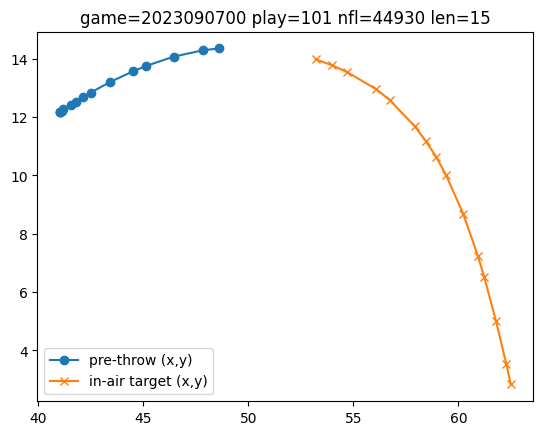

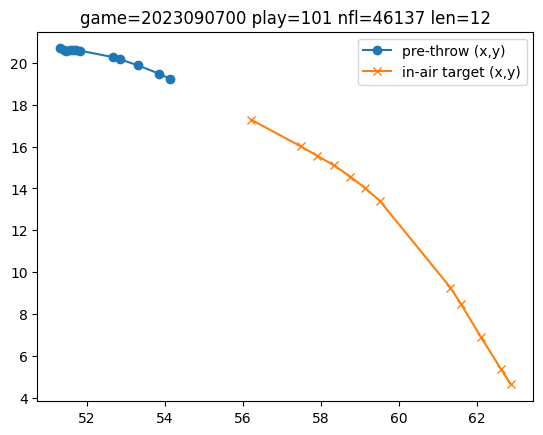

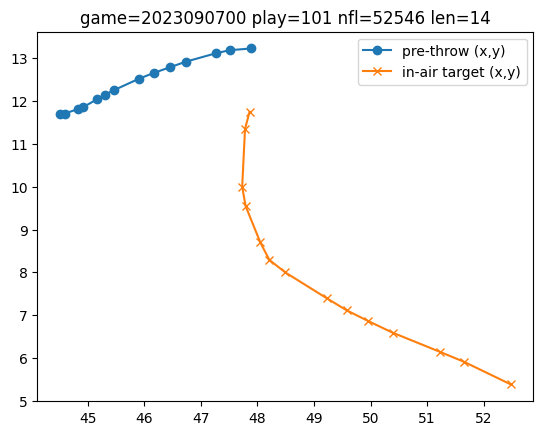

In [38]:
# ================================
# sanity check
# ================================

import matplotlib.pyplot as plt
from itertools import islice

# 아무 시퀀스 3개만 확인
for i, (X, y, frames, key) in enumerate(islice(zip(bundle["X_seqs"], bundle["y_seqs"], bundle["frame_seqs"], bundle["keys"]), 3)):
    plt.figure()
    plt.plot(X[:,0], X[:,1], marker='o', label='pre-throw (x,y)')   # 입력 좌표 궤적
    plt.plot(y[:,0], y[:,1], marker='x', label='in-air target (x,y)') # 타깃 궤적
    plt.title(f"game={key[0]} play={key[1]} nfl={key[2]} len={len(frames)}")
    plt.legend(); plt.show()


v1 Model Creation
================================

In [39]:
# === LSTM Baseline (mini set) : load -> split -> dataloader -> train -> save ===
import os, math, pickle, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# 0) env
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision("high")

# 1) load sequences
with open("/kaggle/working/mini_sequences.pkl","rb") as f:
    bundle = pickle.load(f)
X_list = [torch.tensor(x, dtype=torch.float32) for x in bundle["X_seqs"]]   # (T,6)
Y_list = [torch.tensor(y, dtype=torch.float32) for y in bundle["y_seqs"]]   # (T,2)
keys   = bundle["keys"]
seq_lens = np.array([len(x) for x in X_list])

# 2) split by game (no leakage)
game_ids = np.array([k[0] for k in keys])
uniq_games = np.unique(game_ids)
rng = np.random.default_rng(42); rng.shuffle(uniq_games)
val_games = set(uniq_games[:max(1, int(0.1*len(uniq_games)))])  # ~10% val
idx_train = [i for i,g in enumerate(game_ids) if g not in val_games]
idx_val   = [i for i,g in enumerate(game_ids) if g in  val_games]
print(f"train={len(idx_train)}  val={len(idx_val)}")

# 3) simple bucketing (길이 순 정렬해서 패딩 낭비↓)
def order(idxs): return sorted(idxs, key=lambda j: seq_lens[j])
ord_train, ord_val = order(idx_train), order(idx_val)

class SeqDS(Dataset):
    def __init__(self, idxs): self.idxs = idxs
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i):
        j = self.idxs[i]
        return X_list[j], Y_list[j]

def collate(batch):
    Xs, Ys = zip(*batch)                         # lists of (T,6), (T,2)
    Xpad = pad_sequence(Xs, batch_first=True)    # (B,Tmax,6)
    Ypad = pad_sequence(Ys, batch_first=True)    # (B,Tmax,2)
    lens = torch.tensor([len(x) for x in Xs])
    mask = torch.arange(Xpad.size(1))[None,:] < lens[:,None]  # (B,T)
    return Xpad, Ypad, mask

bs = 256  # GPU면 512~1024로 점진 확대
train_dl = DataLoader(SeqDS(ord_train), batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0, pin_memory=torch.cuda.is_available())
val_dl   = DataLoader(SeqDS(ord_val),   batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0, pin_memory=torch.cuda.is_available())

# 4) model
class LSTMReg(nn.Module):
    def __init__(self, in_dim=6, hid=128, layers=2, out_dim=2, bidir=False, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, num_layers=layers, batch_first=True,
                            bidirectional=bidir, dropout=(dropout if layers>1 else 0.0))
        mult = 2 if bidir else 1
        self.head = nn.Linear(hid*mult, out_dim)
    def forward(self, x):
        h, _ = self.lstm(x)     # (B,T,H[*2])
        return self.head(h)     # (B,T,2)

model = LSTMReg().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def run_epoch(dl, train=True):
    model.train(train)
    total_se, total_n = 0.0, 0
    for X, Y, mask in dl:
        X, Y, mask = X.to(device), Y.to(device), mask.to(device)
        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                pred = model(X)                      # (B,T,2)
                se = ((pred - Y)**2).sum(-1)        # (B,T)
                se_valid = se[mask].sum()           # sum over valid timesteps
                n = int(mask.sum().item())
                rmse = torch.sqrt(se_valid / (n + 1e-9))
            if train:
                opt.zero_grad(set_to_none=True)
                scaler.scale(rmse).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
        total_se += se_valid.detach().item(); total_n += n
    return math.sqrt(total_se / (total_n + 1e-9))

# 5) train
best, best_path = 1e9, "/kaggle/working/lstm_baseline_best.pt"
EPOCHS = 2  # mini에선 1~2로 충분
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_dl, True)
    va = run_epoch(val_dl,   False)
    print(f"[epoch {ep}] train_RMSE={tr:.5f}  val_RMSE={va:.5f}")
    if va < best:
        best = va
        torch.save({"state_dict": model.state_dict(),
                    "cfg":{"in_dim":6,"hid":128,"layers":2,"out_dim":2}}, best_path)
        print(f"  ↳ saved best {best:.5f} → {best_path}")

print("done. best_val_RMSE:", best)


device: cpu
train=41757  val=4275


/tmp/ipykernel_38/1262365252.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_38/1262365252.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[epoch 1] train_RMSE=53.64211  val_RMSE=44.90830
  ↳ saved best 44.90830 → /kaggle/working/lstm_baseline_best.pt
[epoch 2] train_RMSE=36.03934  val_RMSE=31.50013
  ↳ saved best 31.50013 → /kaggle/working/lstm_baseline_best.pt
done. best_val_RMSE: 31.500127921200665


New Sequence Bundle Creation
================================

In [40]:
### 시퀀스 번들 생성 ###

import pandas as pd, numpy as np, pickle

def make_seq_bundle(mini_path, feature_cols, name, extra_fn=None):
    df = pd.read_parquet(mini_path).sort_values(["game_id","play_id","nfl_id","frame_id"]).copy()
    if extra_fn:                      # 피처 엔지니어링 훅
        df = extra_fn(df)

    X_seqs, y_seqs, frame_seqs, keys = [], [], [], []
    for key, g in df.groupby(["game_id","play_id","nfl_id"], sort=False):
        g = g.sort_values("frame_id")
        X_seqs.append(g[feature_cols].to_numpy(np.float32))
        y_seqs.append(g[["target_x","target_y"]].to_numpy(np.float32))
        frame_seqs.append(g["frame_id"].to_numpy(np.int16))
        keys.append(tuple(key))

    bundle = {
        "X_seqs": X_seqs,
        "y_seqs": y_seqs,
        "frame_seqs": frame_seqs,
        "keys": keys,
        "feature_cols": feature_cols,
        "target_cols": ["target_x","target_y"],
        "name": name,
    }
    out_pkl = f"/kaggle/working/{name}.pkl"
    with open(out_pkl, "wb") as f: pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("saved →", out_pkl, "| n_seqs:", len(X_seqs), "| in_dim:", len(feature_cols))
    return out_pkl



In [41]:
BASE_MINI = "/kaggle/working/clean_train_mini.parquet"

def add_rel(df):
    df["rel_x"] = df["x"] - df["ball_land_x"]
    df["rel_y"] = df["y"] - df["ball_land_y"]
    return df

make_seq_bundle(
    BASE_MINI,
    feature_cols=["x","y","s","a","o","dir","rel_x","rel_y"],
    name="mini_sequences_rel",
    extra_fn=add_rel
)


saved → /kaggle/working/mini_sequences_rel.pkl | n_seqs: 46032 | in_dim: 8


'/kaggle/working/mini_sequences_rel.pkl'

Re-running the model
================================

In [42]:
##다시해보기##

# === LSTM baseline (rel features) : load rel bundle -> train -> save ===
import os, math, pickle, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 1) load rel bundle
with open("/kaggle/working/mini_sequences_rel.pkl","rb") as f:
    bundle = pickle.load(f)
X_list = [torch.tensor(x, dtype=torch.float32) for x in bundle["X_seqs"]]   # (T,8)
Y_list = [torch.tensor(y, dtype=torch.float32) for y in bundle["y_seqs"]]   # (T,2)
keys   = bundle["keys"]
seq_lens = np.array([len(x) for x in X_list])
in_dim = len(bundle["feature_cols"])  # == 8

# 2) split by game (no leakage)
game_ids = np.array([k[0] for k in keys])
uniq_games = np.unique(game_ids)
rng = np.random.default_rng(42); rng.shuffle(uniq_games)
val_games = set(uniq_games[:max(1, int(0.1*len(uniq_games)))])
idx_tr = [i for i,g in enumerate(game_ids) if g not in val_games]
idx_va = [i for i,g in enumerate(game_ids) if g in  val_games]
print(f"train={len(idx_tr)}  val={len(idx_va)}")

def order(idxs): return sorted(idxs, key=lambda j: seq_lens[j])
ord_tr, ord_va = order(idx_tr), order(idx_va)

class DS(torch.utils.data.Dataset):
    def __init__(self, idxs): self.idxs = idxs
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i):
        j = self.idxs[i]; return X_list[j], Y_list[j]

def collate(batch):
    Xs, Ys = zip(*batch)
    Xp = pad_sequence(Xs, batch_first=True)     # (B,Tmax,in_dim)
    Yp = pad_sequence(Ys, batch_first=True)     # (B,Tmax,2)
    lens = torch.tensor([len(x) for x in Xs])
    mask = torch.arange(Xp.size(1))[None,:] < lens[:,None]
    return Xp, Yp, mask

bs = 256
dl_tr = DataLoader(DS(ord_tr), batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0, pin_memory=torch.cuda.is_available())
dl_va = DataLoader(DS(ord_va), batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0, pin_memory=torch.cuda.is_available())

# 3) model
class LSTMReg(nn.Module):
    def __init__(self, in_dim, hid=128, layers=2, out_dim=2, bidir=False, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, num_layers=layers, batch_first=True,
                            bidirectional=bidir, dropout=(dropout if layers>1 else 0.0))
        mult = 2 if bidir else 1
        self.head = nn.Linear(hid*mult, out_dim)
    def forward(self, x):
        h,_ = self.lstm(x); return self.head(h)

model = LSTMReg(in_dim=in_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

def run_epoch(dl, train=True):
    model.train(train)
    total_se, total_n = 0.0, 0
    for X,Y,mask in dl:
        X,Y,mask = X.to(device), Y.to(device), mask.to(device)
        pred = model(X)                         # (B,T,2)
        se = ((pred - Y)**2).sum(-1)           # (B,T)
        se_valid = se[mask].sum()
        n = int(mask.sum().item())
        rmse = torch.sqrt(se_valid / (n + 1e-9))
        if train:
            opt.zero_grad(set_to_none=True); rmse.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total_se += float(se_valid.detach()); total_n += n
    return math.sqrt(total_se / (total_n + 1e-9))

# 4) train a couple epochs
best, best_path = 1e9, "/kaggle/working/lstm_rel_best.pt"
for ep in range(1,3):  # mini라 2epoch면 충분히 경향 확인
    tr = run_epoch(dl_tr, True)
    va = run_epoch(dl_va, False)
    print(f"[epoch {ep}] train_RMSE={tr:.5f}  val_RMSE={va:.5f}")
    if va < best:
        best = va
        torch.save({"state_dict": model.state_dict(),
                    "cfg":{"in_dim":in_dim,"hid":128,"layers":2,"out_dim":2}},
                   best_path)
        print(f"  ↳ saved best {best:.5f} → {best_path}")
print("done. best_val_RMSE:", best)


device: cpu
train=41757  val=4275
[epoch 1] train_RMSE=53.55254  val_RMSE=44.66166
  ↳ saved best 44.66166 → /kaggle/working/lstm_rel_best.pt
[epoch 2] train_RMSE=35.76649  val_RMSE=31.28958
  ↳ saved best 31.28958 → /kaggle/working/lstm_rel_best.pt
done. best_val_RMSE: 31.289576541181347


V2 Sequence Bundle
================================

In [43]:
###v2 다시 테스트해보기###

import pandas as pd, numpy as np, pickle

BASE_MINI = "/kaggle/working/clean_train_mini.parquet"

def make_seq_bundle(mini_path, feature_cols, name, extra_fn=None):
    df = pd.read_parquet(mini_path).sort_values(["game_id","play_id","nfl_id","frame_id"]).copy()
    if extra_fn:
        df = extra_fn(df)
    X_seqs, y_seqs, frame_seqs, keys = [], [], [], []
    for key, g in df.groupby(["game_id","play_id","nfl_id"], sort=False):
        g = g.sort_values("frame_id")
        X_seqs.append(g[feature_cols].to_numpy(np.float32))
        y_seqs.append(g[["target_x","target_y"]].to_numpy(np.float32))
        frame_seqs.append(g["frame_id"].to_numpy(np.int16))
        keys.append(tuple(key))
    bundle = {
        "X_seqs": X_seqs, "y_seqs": y_seqs,
        "frame_seqs": frame_seqs, "keys": keys,
        "feature_cols": feature_cols, "target_cols": ["target_x","target_y"]
    }
    out_pkl = f"/kaggle/working/{name}.pkl"
    with open(out_pkl,"wb") as f: pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("saved →", out_pkl, "| n_seqs:", len(X_seqs), "| in_dim:", len(feature_cols))
    return out_pkl

def add_feats(df: pd.DataFrame) -> pd.DataFrame:
    # 상대좌표
    df["rel_x"] = df["x"] - df["ball_land_x"]
    df["rel_y"] = df["y"] - df["ball_land_y"]
    # 각도 원형화
    for col in ["o","dir"]:
        r = np.deg2rad(df[col].astype(float))
        df[f"{col}_cos"] = np.cos(r)
        df[f"{col}_sin"] = np.sin(r)
    # 차분(그룹별)
    df[["dx","dy","ds","dda"]] = (
        df.sort_values(["game_id","play_id","nfl_id","frame_id"])
          .groupby(["game_id","play_id","nfl_id"])[["x","y","s","a"]]
          .diff()
    ).fillna(0.0)
    # 착지점 거리/방위(원형화)
    df["dist_land"] = np.sqrt(df["rel_x"]**2 + df["rel_y"]**2)
    ang = np.arctan2(df["rel_y"], df["rel_x"])
    df["bearing_cos"] = np.cos(ang)
    df["bearing_sin"] = np.sin(ang)
    # 시간 인덱스 정규화
    max_f = df.groupby(["game_id","play_id","nfl_id"])["frame_id"].transform("max").clip(lower=1)
    df["t_norm"] = df["frame_id"] / max_f
    return df

FEATS_V2 = [
    "x","y","s","a",           # 기본
    "rel_x","rel_y",           # 상대
    "o_cos","o_sin","dir_cos","dir_sin",  # 각도 원형화
    "dx","dy","ds","dda",      # 차분
    "dist_land","bearing_cos","bearing_sin",  # 착지점 정보
    "t_norm"                   # 시간
]
_ = make_seq_bundle(
    BASE_MINI,
    feature_cols=FEATS_V2,
    name="mini_sequences_v2",
    extra_fn=add_feats
)


saved → /kaggle/working/mini_sequences_v2.pkl | n_seqs: 46032 | in_dim: 18


In [44]:
import math, pickle, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

with open("/kaggle/working/mini_sequences_v2.pkl","rb") as f:
    bundle = pickle.load(f)

X_list = [torch.tensor(x, dtype=torch.float32) for x in bundle["X_seqs"]]
Y_list = [torch.tensor(y, dtype=torch.float32) for y in bundle["y_seqs"]]
keys = bundle["keys"]; seq_lens = np.array([len(x) for x in X_list])
in_dim = len(bundle["feature_cols"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device, "| in_dim:", in_dim)

game_ids = np.array([k[0] for k in keys])
uniq = np.unique(game_ids); rng = np.random.default_rng(42); rng.shuffle(uniq)
val_games = set(uniq[:max(1,int(0.1*len(uniq)))])
idx_tr = [i for i,g in enumerate(game_ids) if g not in val_games]
idx_va = [i for i,g in enumerate(game_ids) if g in  val_games]

def order(idxs): return sorted(idxs, key=lambda j: seq_lens[j])
ord_tr, ord_va = order(idx_tr), order(idx_va)

class DS(Dataset):
    def __init__(self, idxs): self.idxs = idxs
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i):
        j = self.idxs[i]; return X_list[j], Y_list[j]

def collate(batch):
    Xs, Ys = zip(*batch)
    Xp = pad_sequence(Xs, batch_first=True)
    Yp = pad_sequence(Ys, batch_first=True)
    lens = torch.tensor([len(x) for x in Xs])
    mask = torch.arange(Xp.size(1))[None,:] < lens[:,None]
    return Xp, Yp, mask

bs = 256
dl_tr = DataLoader(DS(ord_tr), batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0, pin_memory=torch.cuda.is_available())
dl_va = DataLoader(DS(ord_va), batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0, pin_memory=torch.cuda.is_available())

class LSTMReg(nn.Module):
    def __init__(self, in_dim, hid=192, layers=2, out_dim=2, dropout=0.1, bidir=False):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, num_layers=layers, batch_first=True,
                            bidirectional=bidir, dropout=(dropout if layers>1 else 0.0))
        mult = 2 if bidir else 1
        self.head = nn.Linear(hid*mult, out_dim)
    def forward(self, x):
        h,_ = self.lstm(x); return self.head(h)

model = LSTMReg(in_dim=in_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

def run_epoch(dl, train=True):
    model.train(train)
    total_se, total_n = 0.0, 0
    for X,Y,mask in dl:
        X,Y,mask = X.to(device), Y.to(device), mask.to(device)
        pred = model(X)
        se = ((pred - Y)**2).sum(-1)
        se_valid = se[mask].sum(); n = int(mask.sum().item())
        rmse = torch.sqrt(se_valid / (n + 1e-9))
        if train:
            opt.zero_grad(set_to_none=True); rmse.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total_se += float(se_valid.detach()); total_n += n
    return math.sqrt(total_se / (total_n + 1e-9))

best, best_path = 1e9, "/kaggle/working/lstm_v2_best.pt"
for ep in range(1,3):
    tr = run_epoch(dl_tr, True)
    va = run_epoch(dl_va, False)
    print(f"[epoch {ep}] train_RMSE={tr:.5f}  val_RMSE={va:.5f}")
    if va < best:
        best = va
        torch.save({"state_dict": model.state_dict(),
                    "cfg":{"in_dim":in_dim,"hid":192,"layers":2,"out_dim":2}}, best_path)
        print(f"  ↳ saved best {best:.5f} → {best_path}")
print("done. best_val_RMSE:", best)


device: cpu | in_dim: 18
[epoch 1] train_RMSE=47.67490  val_RMSE=36.56668
  ↳ saved best 36.56668 → /kaggle/working/lstm_v2_best.pt
[epoch 2] train_RMSE=25.72734  val_RMSE=20.40015
  ↳ saved best 20.40015 → /kaggle/working/lstm_v2_best.pt
done. best_val_RMSE: 20.400150266656855


Mini-set Standardization
================================

In [45]:
# normalize features for v2 bundle (in-place list transform)
import pickle, numpy as np, torch, math
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

with open("/kaggle/working/mini_sequences_v2.pkl","rb") as f:
    b = pickle.load(f)
X_list = [torch.tensor(x, dtype=torch.float32) for x in b["X_seqs"]]
Y_list = [torch.tensor(y, dtype=torch.float32) for y in b["y_seqs"]]
keys = b["keys"]; in_dim = len(b["feature_cols"])

# split by game (no leakage)
game_ids = np.array([k[0] for k in keys])
uniq = np.unique(game_ids); rng = np.random.default_rng(42); rng.shuffle(uniq)
val_games = set(uniq[:max(1,int(0.1*len(uniq)))])
idx_tr = [i for i,g in enumerate(game_ids) if g not in val_games]
idx_va = [i for i,g in enumerate(game_ids) if g in  val_games]

# compute mean/std ONLY on train
def stack_time(seqs):  # (sum_T, D)
    return torch.cat(seqs, dim=0)
mu = stack_time([X_list[i] for i in idx_tr]).mean(0)          # (D,)
sd = stack_time([X_list[i] for i in idx_tr]).std(0).clamp_min(1e-6)  # (D,)

# apply normalize to all X
for i in range(len(X_list)):
    X_list[i] = (X_list[i] - mu) / sd

# dataloaders
lens = np.array([len(x) for x in X_list])
def order(idxs): return sorted(idxs, key=lambda j: lens[j])
class DS(Dataset):
    def __init__(self, idxs): self.idxs = order(idxs)
    def __len__(self): return len(self.idxs)
    def __getitem__(self,i): j=self.idxs[i]; return X_list[j], Y_list[j]
def collate(batch):
    Xs, Ys = zip(*batch)
    Xp = pad_sequence(Xs, batch_first=True)
    Yp = pad_sequence(Ys, batch_first=True)
    L  = torch.tensor([len(x) for x in Xs])
    m  = torch.arange(Xp.size(1))[None,:] < L[:,None]
    return Xp, Yp, m
bs=256
dl_tr = DataLoader(DS(idx_tr), batch_size=bs, shuffle=False, collate_fn=collate)
dl_va = DataLoader(DS(idx_va), batch_size=bs, shuffle=False, collate_fn=collate)

# model
class LSTMReg(nn.Module):
    def __init__(self, in_dim, hid=192, layers=2, out_dim=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, num_layers=layers, batch_first=True, dropout=(dropout if layers>1 else 0.0))
        self.head = nn.Linear(hid, out_dim)
    def forward(self,x):
        h,_ = self.lstm(x); return self.head(h)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMReg(in_dim=in_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

def run_epoch(dl, train=True):
    model.train(train); tot_se=0.0; tot_n=0
    for X,Y,m in dl:
        X,Y,m = X.to(device), Y.to(device), m.to(device)
        pred = model(X)
        se = ((pred - Y)**2).sum(-1)     # (B,T)
        se_v = se[m].sum(); n = int(m.sum())
        rmse = torch.sqrt(se_v / (n + 1e-9))
        if train:
            opt.zero_grad(set_to_none=True); rmse.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            opt.step()
        tot_se += float(se_v.detach()); tot_n += n
    return math.sqrt(tot_se / (tot_n + 1e-9))

best=1e9
for ep in range(1,3):
    tr = run_epoch(dl_tr, True)
    va = run_epoch(dl_va, False)
    print(f"[norm][epoch {ep}] train_RMSE={tr:.5f}  val_RMSE={va:.5f}")
    best = min(best, va)
print("best_val_RMSE (norm):", best)


[norm][epoch 1] train_RMSE=48.88671  val_RMSE=37.01168
[norm][epoch 2] train_RMSE=28.99188  val_RMSE=23.86942
best_val_RMSE (norm): 23.869421661554803


v2.pkl re-training with BiLSTM 256
================================

In [46]:
import math, pickle, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

with open("/kaggle/working/mini_sequences_v2.pkl","rb") as f:
    bundle = pickle.load(f)

X_list = [torch.tensor(x, dtype=torch.float32) for x in bundle["X_seqs"]]
Y_list = [torch.tensor(y, dtype=torch.float32) for y in bundle["y_seqs"]]
keys = bundle["keys"]; L = np.array([len(x) for x in X_list])
in_dim = len(bundle["feature_cols"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device, "| in_dim:", in_dim)

game_ids = np.array([k[0] for k in keys])
uniq = np.unique(game_ids); rng = np.random.default_rng(42); rng.shuffle(uniq)
val_games = set(uniq[:max(1,int(0.1*len(uniq)))])
idx_tr = [i for i,g in enumerate(game_ids) if g not in val_games]
idx_va = [i for i,g in enumerate(game_ids) if g in  val_games]

def order(idxs): return sorted(idxs, key=lambda j: L[j])
class DS(Dataset):
    def __init__(self, idxs): self.idxs = order(idxs)
    def __len__(self): return len(self.idxs)
    def __getitem__(self,i): j=self.idxs[i]; return X_list[j], Y_list[j]
def collate(batch):
    Xs, Ys = zip(*batch)
    Xp = pad_sequence(Xs, batch_first=True)
    Yp = pad_sequence(Ys, batch_first=True)
    lens = torch.tensor([len(x) for x in Xs])
    mask = torch.arange(Xp.size(1))[None,:] < lens[:,None]
    return Xp, Yp, mask

bs = 256
dl_tr = DataLoader(DS(idx_tr), batch_size=bs, shuffle=False, collate_fn=collate)
dl_va = DataLoader(DS(idx_va), batch_size=bs, shuffle=False, collate_fn=collate)

class LSTMReg(nn.Module):
    def __init__(self, in_dim, hid=256, layers=2, out_dim=2, dropout=0.2, bidir=True):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, num_layers=layers, batch_first=True,
                            bidirectional=bidir, dropout=(dropout if layers>1 else 0.0))
        mult = 2 if bidir else 1
        self.head = nn.Linear(hid*mult, out_dim)
    def forward(self, x):
        h,_ = self.lstm(x); return self.head(h)

model = LSTMReg(in_dim=in_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=1e-4)

def run_epoch(dl, train=True):
    model.train(train); tot_se=0.0; tot_n=0
    for X,Y,m in dl:
        X,Y,m = X.to(device), Y.to(device), m.to(device)
        pred = model(X)
        se = ((pred - Y)**2).sum(-1)
        se_v = se[m].sum(); n = int(m.sum().item())
        rmse = torch.sqrt(se_v / (n + 1e-9))
        if train:
            opt.zero_grad(set_to_none=True); rmse.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        tot_se += float(se_v.detach()); tot_n += n
    return math.sqrt(tot_se / (tot_n + 1e-9))

best, best_path = 1e9, "/kaggle/working/lstm_v2_bilstm256_best.pt"
for ep in range(1,3):
    tr = run_epoch(dl_tr, True)
    va = run_epoch(dl_va, False)
    print(f"[BiLSTM256][epoch {ep}] train_RMSE={tr:.5f}  val_RMSE={va:.5f}")
    if va < best:
        best = va
        torch.save({"state_dict": model.state_dict(),
                    "cfg":{"in_dim":in_dim,"hid":256,"layers":2,"out_dim":2,"bidir":True}}, best_path)
        print(f"  ↳ saved best {best:.5f} → {best_path}")
print("done. best_val_RMSE:", best)


device: cpu | in_dim: 18
[BiLSTM256][epoch 1] train_RMSE=35.21224  val_RMSE=22.40653
  ↳ saved best 22.40653 → /kaggle/working/lstm_v2_bilstm256_best.pt
[BiLSTM256][epoch 2] train_RMSE=12.46431  val_RMSE=10.62508
  ↳ saved best 10.62508 → /kaggle/working/lstm_v2_bilstm256_best.pt
done. best_val_RMSE: 10.625075592784343


Sharding
================================

In [47]:
# === Build full sequences v2 (per-week shards) : input + output merge ===
import os, gc, json, numpy as np, pandas as pd, pickle

RAW_DIR = "/kaggle/input/nfl-big-data-bowl-2026-prediction/train"
OUT_DIR = "/kaggle/working/full_v2_shards"
os.makedirs(OUT_DIR, exist_ok=True)

FEATS_V2 = [
    "x","y","s","a",
    "rel_x","rel_y",
    "o_cos","o_sin","dir_cos","dir_sin",
    "dx","dy","ds","dda",
    "dist_land","bearing_cos","bearing_sin",
    "t_norm"
]

def add_feats(df: pd.DataFrame) -> pd.DataFrame:
    # 정렬
    df = df.sort_values(["game_id","play_id","nfl_id","frame_id"]).copy()
    # 상대좌표
    df["rel_x"] = df["x"] - df["ball_land_x"]
    df["rel_y"] = df["y"] - df["ball_land_y"]
    # 각도 원형화
    for col in ["o","dir"]:
        r = np.deg2rad(df[col].astype(float))
        df[f"{col}_cos"] = np.cos(r); df[f"{col}_sin"] = np.sin(r)
    # 차분(그룹별)
    diffs = (
        df.groupby(["game_id","play_id","nfl_id"])[["x","y","s","a"]]
          .diff()
          .rename(columns={"x":"dx","y":"dy","s":"ds","a":"dda"})
    )
    df[["dx","dy","ds","dda"]] = diffs.fillna(0.0)
    # 착지점 거리/방위
    df["dist_land"] = np.sqrt(df["rel_x"]**2 + df["rel_y"]**2)
    ang = np.arctan2(df["rel_y"], df["rel_x"])
    df["bearing_cos"] = np.cos(ang); df["bearing_sin"] = np.sin(ang)
    # 시간 정규화(그룹별 최대 프레임으로 0~1)
    max_f = df.groupby(["game_id","play_id","nfl_id"])["frame_id"].transform("max").clip(lower=1)
    df["t_norm"] = df["frame_id"] / max_f
    return df

manifest = []
weeks = [f"{i:02d}" for i in range(1, 19)]
for w in weeks:
    in_path  = f"{RAW_DIR}/input_2023_w{w}.csv"   # pre-throw
    out_path = f"{RAW_DIR}/output_2023_w{w}.csv"  # in-air targets
    print(f"[w{w}] loading...")
    di = pd.read_csv(in_path)
    do = pd.read_csv(out_path)

    # 각 그룹(T 길이)을 위해 도우미 dict 구성: y 시퀀스
    # do에는 (game_id, play_id, nfl_id, frame_id, x, y)가 있음
    # → y를 그룹별로 정렬하고 np.array로 저장
    do = do.sort_values(["game_id","play_id","nfl_id","frame_id"])
    y_map = {
        k: g[["x","y"]].to_numpy(np.float32)
        for k, g in do.groupby(["game_id","play_id","nfl_id"], sort=False)
    }

    # 입력은 pre-throw 프레임들 → 각 그룹에서 T = num_frames_output
    # 마지막 T프레임만 사용하여 X 시퀀스를 만들고, y_map[k]와 길이 맞춰 사용
    di = di.sort_values(["game_id","play_id","nfl_id","frame_id"]).copy()

    X_seqs, y_seqs, frame_seqs, keys = [], [], [], []
    for k, g in di.groupby(["game_id","play_id","nfl_id"], sort=False):
        T = int(g["num_frames_output"].iloc[0])
        if T <= 0:  # 방어
            continue
        # 타깃이 없는 플레이(드롭/예외 등) 방어
        y = y_map.get(k, None)
        if y is None or len(y) < T:
            continue
        # 입력은 던지기 직전 프레임들의 마지막 T개
        gi = g.sort_values("frame_id")
        if len(gi) < T:
            # 입력 프레임이 부족하면 건너뜀
            continue
        gi_T = gi.tail(T).copy()
        gi_T = add_feats(gi_T)

        X_seqs.append(gi_T[FEATS_V2].to_numpy(np.float32))
        y_seqs.append(y[:T])  # y도 앞쪽 T프레임만
        frame_seqs.append(gi_T["frame_id"].to_numpy(np.int16))
        keys.append(tuple(k))

    bundle = {
        "X_seqs": X_seqs, "y_seqs": y_seqs,
        "frame_seqs": frame_seqs, "keys": keys,
        "feature_cols": FEATS_V2, "target_cols": ["target_x","target_y"],  # 관례상 표기만 유지
        "week": w,
    }
    out_pkl = f"{OUT_DIR}/full_sequences_v2_w{w}.pkl"
    with open(out_pkl, "wb") as f: pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)
    manifest.append((w, out_pkl, len(X_seqs)))
    print(f"[w{w}] saved → {out_pkl} | n_seqs={len(X_seqs)}")
    del di, do, X_seqs, y_seqs, frame_seqs, keys, bundle; gc.collect()

# 매니페스트 저장
man_path = f"{OUT_DIR}/manifest.json"
with open(man_path, "w") as f: json.dump(manifest, f)
print("manifest saved:", man_path, "| weeks:", len(manifest))


[w01] loading...
[w01] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w01.pkl | n_seqs=2633
[w02] loading...
[w02] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w02.pkl | n_seqs=2716
[w03] loading...
[w03] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w03.pkl | n_seqs=2923
[w04] loading...
[w04] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w04.pkl | n_seqs=2489
[w05] loading...
[w05] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w05.pkl | n_seqs=2431
[w06] loading...
[w06] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w06.pkl | n_seqs=2558
[w07] loading...
[w07] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w07.pkl | n_seqs=2253
[w08] loading...
[w08] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w08.pkl | n_seqs=2670
[w09] loading...
[w09] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w09.pkl | n_seqs=2259
[w10] loading...
[w10] saved → /kaggle/working/full_v2_shards/full_sequences_v2_w1

full training
================================

In [48]:
# w01 성공 확인 후 전체 루프
import os, gc, json, numpy as np, pandas as pd, pickle

RAW_DIR = "/kaggle/input/nfl-big-data-bowl-2026-prediction/train"
OUT_DIR = "/kaggle/working/full_v2_shards"
os.makedirs(OUT_DIR, exist_ok=True)

FEATS_V2 = [
    "x","y","s","a",
    "rel_x","rel_y",
    "o_cos","o_sin","dir_cos","dir_sin",
    "dx","dy","ds","dda",
    "dist_land","bearing_cos","bearing_sin",
    "t_norm"
]

def add_feats(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["game_id","play_id","nfl_id","frame_id"]).copy()
    df["rel_x"] = df["x"] - df["ball_land_x"]; df["rel_y"] = df["y"] - df["ball_land_y"]
    for col in ["o","dir"]:
        r = np.deg2rad(df[col].astype(float))
        df[f"{col}_cos"] = np.cos(r); df[f"{col}_sin"] = np.sin(r)
    diffs = (
        df.groupby(["game_id","play_id","nfl_id"])[["x","y","s","a"]]
          .diff()
          .rename(columns={"x":"dx","y":"dy","s":"ds","a":"dda"})
    )
    df[["dx","dy","ds","dda"]] = diffs.fillna(0.0)
    df["dist_land"] = np.sqrt(df["rel_x"]**2 + df["rel_y"]**2)
    ang = np.arctan2(df["rel_y"], df["rel_x"])
    df["bearing_cos"] = np.cos(ang); df["bearing_sin"] = np.sin(ang)
    max_f = df.groupby(["game_id","play_id","nfl_id"])["frame_id"].transform("max").clip(lower=1)
    df["t_norm"] = df["frame_id"] / max_f
    return df

manifest = []
weeks = [f"{i:02d}" for i in range(1,19)]
for w in weeks:
    out_pkl = f"{OUT_DIR}/full_sequences_v2_w{w}.pkl"
    if os.path.exists(out_pkl):
        # 이미 만들어진 주차는 스킵 (중간 재시작 대비)
        sz = os.path.getsize(out_pkl)
        print(f"[w{w}] skip (exists, {sz/1e6:.1f}MB): {out_pkl}")
        with open(out_pkl,"rb") as f: nseq = len(pickle.load(f)["X_seqs"])
        manifest.append((w, out_pkl, nseq))
        continue

    in_path  = f"{RAW_DIR}/input_2023_w{w}.csv"
    out_path = f"{RAW_DIR}/output_2023_w{w}.csv"
    print(f"[w{w}] building ...")
    di = pd.read_csv(in_path).sort_values(["game_id","play_id","nfl_id","frame_id"])
    do = pd.read_csv(out_path).sort_values(["game_id","play_id","nfl_id","frame_id"])
    y_map = {k: g[["x","y"]].to_numpy(np.float32) for k,g in do.groupby(["game_id","play_id","nfl_id"], sort=False)}

    X_seqs, y_seqs, frame_seqs, keys = [], [], [], []
    for k, g in di.groupby(["game_id","play_id","nfl_id"], sort=False):
        T = int(g["num_frames_output"].iloc[0]); 
        if T <= 0: 
            continue
        y = y_map.get(k, None)
        if y is None or len(y) < T:
            continue
        gi = g.sort_values("frame_id")
        if len(gi) < T:
            continue
        gi_T = add_feats(gi.tail(T).copy())
        X_seqs.append(gi_T[FEATS_V2].to_numpy(np.float32))
        y_seqs.append(y[:T])
        frame_seqs.append(gi_T["frame_id"].to_numpy(np.int16))
        keys.append(tuple(k))

    with open(out_pkl, "wb") as f:
        pickle.dump({"X_seqs":X_seqs,"y_seqs":y_seqs,"frame_seqs":frame_seqs,"keys":keys,
                     "feature_cols":FEATS_V2,"target_cols":["target_x","target_y"],"week":w}, f,
                    protocol=pickle.HIGHEST_PROTOCOL)
    manifest.append((w, out_pkl, len(X_seqs)))
    print(f"[w{w}] saved → {out_pkl} | n_seqs={len(X_seqs)}")

    del di, do, X_seqs, y_seqs, frame_seqs, keys; gc.collect()

# manifest 저장
import json
man_path = f"{OUT_DIR}/manifest.json"
with open(man_path,"w") as f: json.dump(manifest, f)
print("manifest saved:", man_path, "| weeks:", len(manifest))


[w01] skip (exists, 2.9MB): /kaggle/working/full_v2_shards/full_sequences_v2_w01.pkl
[w02] skip (exists, 3.0MB): /kaggle/working/full_v2_shards/full_sequences_v2_w02.pkl
[w03] skip (exists, 3.4MB): /kaggle/working/full_v2_shards/full_sequences_v2_w03.pkl
[w04] skip (exists, 2.8MB): /kaggle/working/full_v2_shards/full_sequences_v2_w04.pkl
[w05] skip (exists, 2.8MB): /kaggle/working/full_v2_shards/full_sequences_v2_w05.pkl
[w06] skip (exists, 2.9MB): /kaggle/working/full_v2_shards/full_sequences_v2_w06.pkl
[w07] skip (exists, 2.5MB): /kaggle/working/full_v2_shards/full_sequences_v2_w07.pkl
[w08] skip (exists, 3.1MB): /kaggle/working/full_v2_shards/full_sequences_v2_w08.pkl
[w09] skip (exists, 2.6MB): /kaggle/working/full_v2_shards/full_sequences_v2_w09.pkl
[w10] skip (exists, 2.7MB): /kaggle/working/full_v2_shards/full_sequences_v2_w10.pkl
[w11] skip (exists, 2.6MB): /kaggle/working/full_v2_shards/full_sequences_v2_w11.pkl
[w12] skip (exists, 3.0MB): /kaggle/working/full_v2_shards/full_s

In [49]:
import glob, json, os
print("manifest?", os.path.exists("/kaggle/working/full_v2_shards/manifest.json"))
print("num shards:", len(glob.glob("/kaggle/working/full_v2_shards/full_sequences_v2_w*.pkl")))


manifest? True
num shards: 18


In [50]:
import glob, json, os, pickle

SHARD_DIR = "/kaggle/working/full_v2_shards"
os.makedirs(SHARD_DIR, exist_ok=True)

# 이미 저장된 .pkl 파일 목록 다시 스캔해서 manifest 복원
pkl_files = sorted(glob.glob(f"{SHARD_DIR}/full_sequences_v2_w*.pkl"))
manifest = []
for p in pkl_files:
    with open(p, "rb") as f:
        nseq = len(pickle.load(f)["X_seqs"])
    week = p.split("_w")[-1].split(".")[0]
    manifest.append((week, p, nseq))

man_path = f"{SHARD_DIR}/manifest.json"
with open(man_path, "w") as f:
    json.dump(manifest, f)

print(f"✅ manifest rebuilt: {man_path} | shards: {len(manifest)}")


✅ manifest rebuilt: /kaggle/working/full_v2_shards/manifest.json | shards: 18


B 단계

In [51]:
# === Train streaming on shards (v2 feats) ===
import os, json, math, pickle, numpy as np, torch, torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

SHARD_DIR = "/kaggle/working/full_v2_shards"
MANIFEST = f"{SHARD_DIR}/manifest.json"
with open(MANIFEST,"r") as f:
    manifest = json.load(f)  # list of [week, path, nseqs]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device, "| #GPU:", torch.cuda.device_count())

# --- 게임 기준 split을 위한 간단 샘플링: 주차 1~16 train, 17~18 val (보수적 누출 방지)
train_shards = [p for (w,p,_) in manifest if int(w) <= 16]
val_shards   = [p for (w,p,_) in manifest if int(w) >= 17]
print("train_shards:", len(train_shards), "val_shards:", len(val_shards))

# --- IterableDataset: shard-by-shard streaming
class ShardSeqs(IterableDataset):
    def __init__(self, shard_paths):
        self.paths = shard_paths
    def __iter__(self):
        for sp in self.paths:
            with open(sp, "rb") as f:
                b = pickle.load(f)
            Xs = b["X_seqs"]; Ys = b["y_seqs"]
            # 길이 순 정렬로 패딩 낭비↓
            order = sorted(range(len(Xs)), key=lambda i: len(Xs[i]))
            for i in order:
                yield torch.tensor(Xs[i], dtype=torch.float32), torch.tensor(Ys[i], dtype=torch.float32)

def collate(batch):
    Xs, Ys = zip(*batch)
    Xp = pad_sequence(Xs, batch_first=True)     # (B,T,D)
    Yp = pad_sequence(Ys, batch_first=True)     # (B,T,2)
    lens = torch.tensor([len(x) for x in Xs])
    mask = torch.arange(Xp.size(1))[None,:] < lens[:,None]
    return Xp, Yp, mask

bs = 512 if torch.cuda.is_available() else 256
train_dl = DataLoader(ShardSeqs(train_shards), batch_size=bs, collate_fn=collate, num_workers=2, pin_memory=torch.cuda.is_available())
val_dl   = DataLoader(ShardSeqs(val_shards),   batch_size=bs, collate_fn=collate, num_workers=2, pin_memory=torch.cuda.is_available())

# --- Model (BiLSTM 256)
class LSTMReg(nn.Module):
    def __init__(self, in_dim, hid=256, layers=2, out_dim=2, dropout=0.2, bidir=True):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, num_layers=layers, batch_first=True,
                            bidirectional=bidir, dropout=(dropout if layers>1 else 0.0))
        mult = 2 if bidir else 1
        self.head = nn.Linear(hid*mult, out_dim)
    def forward(self, x):
        h,_ = self.lstm(x); return self.head(h)

# in_dim은 아무 샤드 하나를 열어 확인
with open(train_shards[0],"rb") as f:
    sample = pickle.load(f)
in_dim = len(sample["feature_cols"])
model = LSTMReg(in_dim=in_dim).to(device)

# --- Optim, Scheduler, AMP
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=1, T_mult=2)
amp_enabled = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

def run_epoch(dl, train=True):
    model.train(train)
    tot_se, tot_n = 0.0, 0
    for X,Y,m in dl:
        X,Y,m = X.to(device), Y.to(device), m.to(device)
        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=amp_enabled):
                pred = model(X)
                se = ((pred - Y)**2).sum(-1)
                se_v = se[m].sum(); n = int(m.sum().item())
                rmse = torch.sqrt(se_v / (n + 1e-9))
            if train:
                opt.zero_grad(set_to_none=True)
                scaler.scale(rmse).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
                sched.step()  # per-batch cosine
        tot_se += float(se_v.detach()); tot_n += n
    return math.sqrt(tot_se / (tot_n + 1e-9))

best, best_path = 1e9, "/kaggle/working/full_lstm_v2_bilstm256_best.pt"
EPOCHS = 3  # full에서는 3~4epoch 권장(9h 제한 내)
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_dl, True)
    va = run_epoch(val_dl,   False)
    print(f"[FULL][epoch {ep}] train_RMSE={tr:.5f}  val_RMSE={va:.5f}")
    if va < best:
        best = va
        torch.save({"state_dict": model.state_dict(),
                    "cfg":{"in_dim":in_dim,"hid":256,"layers":2,"out_dim":2,"bidir":True}},
                   best_path)
        print(f"  ↳ saved best {best:.5f} → {best_path}")
print("done. best_val_RMSE:", best)


device: cpu | #GPU: 0
train_shards: 16 val_shards: 2


/tmp/ipykernel_38/3856247462.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
/tmp/ipykernel_38/3856247462.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):


[FULL][epoch 1] train_RMSE=32.81057  val_RMSE=11.50484
  ↳ saved best 11.50484 → /kaggle/working/full_lstm_v2_bilstm256_best.pt
[FULL][epoch 2] train_RMSE=7.82073  val_RMSE=5.15097
  ↳ saved best 5.15097 → /kaggle/working/full_lstm_v2_bilstm256_best.pt
[FULL][epoch 3] train_RMSE=4.36335  val_RMSE=3.27400
  ↳ saved best 3.27400 → /kaggle/working/full_lstm_v2_bilstm256_best.pt
done. best_val_RMSE: 3.2739961919742644


In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_inference_server.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluati

In [54]:
import polars as pl
import pandas as pd
import kaggle_evaluation.nfl_inference_server
import os

def predict(test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame | pd.DataFrame:
    predictions = pl.DataFrame({'x': [0.0] * len(test), 'y': [0.0] * len(test)})
    assert isinstance(predictions, (pd.DataFrame, pl.DataFrame))
    assert len(predictions) == len(test)
    return predictions

inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        ('/kaggle/input/nfl-big-data-bowl-2026-prediction/',)
    )
